In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph as ig
from collections import Counter
from efficient_apriori import apriori
import math

from src import acgraph as acg
from src import utils as ut

In [4]:
def get_norm_degdistrib(g, isbottom = True):

    vidx_to_deg = dict()
    for v in g.vs:
        if v['type'] == isbottom:
            vidx_to_deg[v.index] = v.degree()
    
    degrees = list(vidx_to_deg.values())
    degree_counter = Counter(degrees)
    degree_keys = list(degree_counter.keys())
    counts = list(degree_counter.values())

    #sorting list based on another list
    #https://stackoverflow.com/questions/6618515/sorting-list-based-on-values-from-another-list
    temp = {degkey:count for degkey,count in sorted(zip(degree_keys, counts))}
    deg_ks = list(temp.keys())
    deg_distr = list(temp.values())

    total = sum(deg_distr)
    p_k = [frec/total for frec in deg_distr] #norm distribution

    
    return vidx_to_deg, dict(zip(deg_ks,p_k))

In [18]:
from scipy.optimize import curve_fit
def power_law(x, a, b):
    return a * np.power(x, -b)

def st_exp(x,c,tau,miu):
    return c*(np.exp(-(x/tau)**miu))


In [6]:
def save_xytable(fname,x,y,xlabel,ylabel):
    f = open(fname,'w')
    strout = xlabel + ' ' + ylabel + '\n'
    f.write(strout)
    for i in range(len(x)):
        strout = str(x[i]) + ' ' + str(y[i]) + '\n'
        f.write(strout)
    f.close()

In [25]:
def degree_corr(g, vidx_to_deg):
    deg_to_vidxs = dict()
    for vidx,deg in vidx_to_deg.items():
        if not deg in deg_to_vidxs:
            deg_to_vidxs[deg] = []
        deg_to_vidxs[deg].append(vidx)
    
    deg_to_avgdeg = dict()
    for deg,vidxs in deg_to_vidxs.items():
        vidxs2 = []
        for vidx in vidxs:
            for vidx2 in g.neighbors(g.vs[vidx]):
                vidxs2.append(vidx2)
        
        avgdeg = sum([g.vs[vidx2].degree() for vidx2 in vidxs2])/len(vidxs2)
        deg_to_avgdeg[deg] = avgdeg
    
    deg_to_avgdeg = dict(sorted(deg_to_avgdeg.items(), key=lambda item: item[0]))
    return deg_to_avgdeg 

### Load access control graph

In [7]:
rel_attnames = [
#'MGR_ID',
#'ROLE_ROLLUP_1',
'ROLE_ROLLUP_2',
'ROLE_DEPTNAME',
'ROLE_TITLE',
'ROLE_FAMILY_DESC',
'ROLE_FAMILY']
gur = acg.load_azkag_graph(rel_attnames=rel_attnames, isWeighted=True)
print('---Control Access Graph---')
print('Total edges:', len(gur.es))
print('Total vertices:', len(gur.vs))

gur_usrlabels,gur_reslabels = acg.get_labels(gur, byweights=False)
print('Num users:',len(gur_usrlabels))
print('Num resources:', len(gur_reslabels))
print()

gur = acg.get_largestcc(gur) #Discard small components
print('---Largest Connected Component---')
print('Total edges:', len(gur.es))
print('Total vertices:', len(gur.vs))
usrlabels,reslabels = acg.get_labels(gur, byweights=False)
print('Num users:',len(usrlabels))
print('Num resources:', len(reslabels))

---Control Access Graph---
Total edges: 30872
Total vertices: 16524
Num users: 9298
Num resources: 7226

---Largest Connected Component---
Total edges: 30425
Total vertices: 15773
Num users: 8933
Num resources: 6840


### Resoure degree distribution

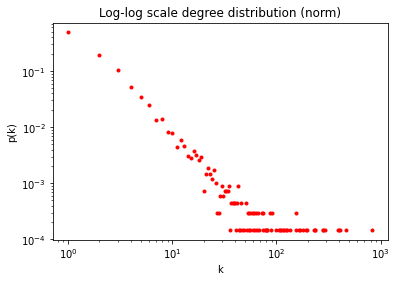

In [14]:
#Degree distribution
vidx_to_deg_res, degs_to_pks = get_norm_degdistrib(gur, isbottom = True)
degs_res = list(degs_to_pks.keys())
pks_res = list(degs_to_pks.values())

plt.loglog(degs_res,pks_res,'r.')
plt.title('Log-log scale degree distribution (norm)')
plt.ylabel('p(k)')
plt.xlabel('k')
plt.show()

Alpha: 2.258383903101027


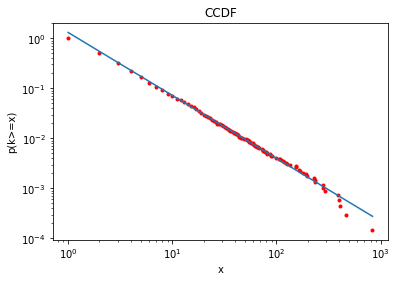

In [16]:
#Complement of the cumulative distribution function (CCDF)
Pks_res = []
s = 0
for pk in pks_res:
    Pks_res.append(1-s)
    s += pk

minidx = 10
maxidx = 100
popt, pcov = curve_fit(power_law, degs_res[minidx:maxidx], Pks_res[minidx:maxidx], p0=[1, 1], bounds=[[1e-3, 1e-3], [1e20, 50]])
print('Alpha:',popt[1]+1)

Pksfit_res = power_law(degs_res, *popt)

plt.loglog(degs_res,Pks_res,'r.')
plt.loglog(degs_res[:len(Pksfit_res)], Pksfit_res)
plt.title('CCDF')
plt.ylabel('p(k>=x)')
plt.xlabel('x')
plt.show()

In [15]:
#Save plots
fname = 'dats/ch4_azkag_res_degdistrib.dat'
#save_xytable(fname,x=degs_res,y=pks_res,xlabel='k',ylabel='p')

fname = 'dats/ch4_azkag_res_ccdf.dat'
save_xytable(fname,x=degs_res,y=Pks_res,xlabel='x',ylabel='P')

fname = 'dats/ch4_azkag_res_ccdf_fit.dat'
save_xytable(fname,x=degs_res[:len(Pksfit_res)],y=Pksfit_res,xlabel='x',ylabel='P')

### User degree distribution

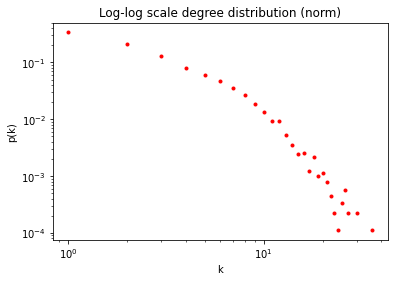

In [17]:
vidx_to_deg_usr, degs_to_pks = get_norm_degdistrib(gur, isbottom = False)
degs_usr = list(degs_to_pks.keys())
pks_usr = list(degs_to_pks.values())

plt.loglog(degs_usr,pks_usr,'r.')
plt.title('Log-log scale degree distribution (norm)')
plt.ylabel('p(k)')
plt.xlabel('k')
plt.show()

/var/folders/4z/6ntcmwbx3_s3ybystwpytzsw0000gn/T/ipykernel_2277/2811307370.py:6: RuntimeWarning: invalid value encountered in power
  return c*(np.exp(-(x/tau)**miu))


Mu: 0.7755718083913512


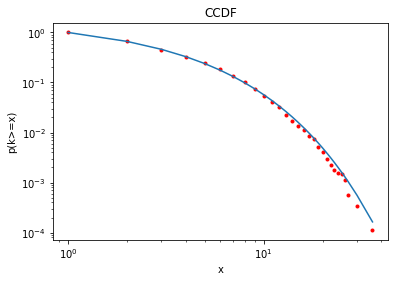

In [23]:
#Complement of the cumulative distribution function (CCDF)
Pks_usr = []
s = 0
for pk in pks_usr:
    Pks_usr.append(1-s)
    s += pk

minidx = 0
maxidx = 60
best_vals, covar = curve_fit(st_exp, degs_usr[minidx:maxidx], Pks_usr[minidx:maxidx], p0=[1.0, 1.0, 1.0])
Pksfit_usr = st_exp(degs_usr, *best_vals)

print('Mu:',best_vals[2])

plt.loglog(degs_usr,Pks_usr,'r.')
plt.loglog(degs_usr[:len(Pksfit_usr)], Pksfit_usr)
plt.title('CCDF')
plt.ylabel('p(k>=x)')
plt.xlabel('x')
plt.show()

In [24]:
#Save plots
fname = 'dats/ch4_azkag_usr_degdistrib.dat'
#save_xytable(fname,x=degs_usr,y=pks_usr,xlabel='k',ylabel='p')

fname = 'dats/ch4_azkag_usr_ccdf.dat'
save_xytable(fname,x=degs_usr,y=Pks_usr,xlabel='x',ylabel='P')

fname = 'dats/ch4_azkag_usr_ccdf_fit.dat'
save_xytable(fname,x=degs_usr[:len(Pksfit_usr)],y=Pksfit_usr,xlabel='x',ylabel='P')

### Degree correlations (resources)

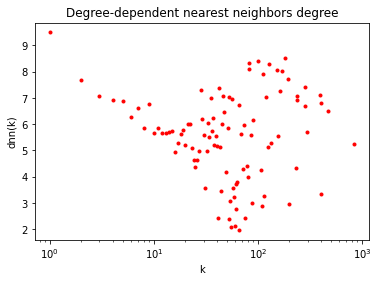

In [37]:
deg_to_avgdeg = degree_corr(gur, vidx_to_deg_res)
x = list(deg_to_avgdeg.keys())
y = list(deg_to_avgdeg.values())
plt.semilogx(x,y,'r.')
plt.title('Degree-dependent nearest neighbors degree')
plt.ylabel('dnn(k)')
plt.xlabel('k')
plt.show()

#fname = 'dats/ch4_azkag_res_avgdeg.dat'
#save_xytable(fname,x=x,y=y,xlabel='k',ylabel='d')

### Degree correlations (users)

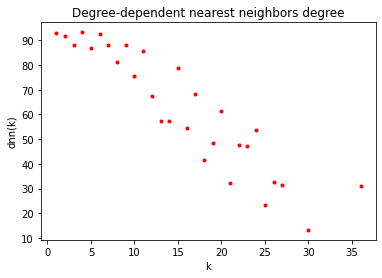

In [39]:
deg_to_avgdeg = degree_corr(gur, vidx_to_deg_usr)
x = list(deg_to_avgdeg.keys())
y = list(deg_to_avgdeg.values())
plt.plot(x,y,'r.')
plt.title('Degree-dependent nearest neighbors degree')
plt.ylabel('dnn(k)')
plt.xlabel('k')
plt.show()

fname = 'dats/ch4_azkag_usr_avgdeg.dat'
save_xytable(fname,x=x,y=y,xlabel='k',ylabel='d')